Student Performance : C++ vs skLearn (SGD)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sys

# Resolve repo root by searching upwards for the data folder
if '__file__' in globals():
    base = Path(__file__).resolve()
else:
    base = Path().resolve()
ROOT = None
for cand in [base, *base.parents]:
    if (cand / 'data' / 'Student_Performance.csv').exists():
        ROOT = cand
        break
if ROOT is None:
    raise FileNotFoundError('Could not locate data/Student_Performance.csv')

# Ensure C++ extension module is importable when running interactively
build_dir = ROOT / 'build'
if str(build_dir) not in sys.path:
    sys.path.insert(0, str(build_dir))

import shared_c_ext


# Resolve repo root by searching upwards for the data folder
if '__file__' in globals():
    base = Path(__file__).resolve()
else:
    base = Path().resolve()
ROOT = None
for cand in [base, *base.parents]:
    if (cand / 'data' / 'Student_Performance.csv').exists():
        ROOT = cand
        break
if ROOT is None:
    raise FileNotFoundError('Could not locate data/Student_Performance.csv')

data_path = ROOT / 'data' / 'Student_Performance.csv'

# Ensure C++ extension module is importable when running interactively
build_dir = ROOT / 'build'
if str(build_dir) not in sys.path:
    sys.path.insert(0, str(build_dir))

df = pd.read_csv(data_path)
feature_cols = df.columns[:-1]
target_col = df.columns[-1]
X = df[feature_cols].to_numpy(dtype=float)
y = df[target_col].to_numpy(dtype=float)

# Train/test split and standardize features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

learning_rate = 0.05
epochs = 1000

# C++ model via pybind
cpp_model = shared_c_ext.LinearRegression(learning_rate)
cpp_model.fit(X_train_s.tolist(), y_train.tolist(), epochs)
cpp_train_pred = np.array(cpp_model.predict(X_train_s.tolist()))
cpp_test_pred = np.array(cpp_model.predict(X_test_s.tolist()))
cpp_mse_train = mean_squared_error(y_train, cpp_train_pred) / 2.0
cpp_mse_test = mean_squared_error(y_test, cpp_test_pred) / 2.0

# sklearn SGDRegressor with matching hyperparams
sgd = SGDRegressor(loss='squared_error', penalty=None, learning_rate='constant', eta0=learning_rate, max_iter=epochs, tol=1e-9, random_state=42)
sgd.fit(X_train_s, y_train)
sk_train_pred = sgd.predict(X_train_s)
sk_test_pred = sgd.predict(X_test_s)
sk_mse_train = mean_squared_error(y_train, sk_train_pred) / 2.0
sk_mse_test = mean_squared_error(y_test, sk_test_pred) / 2.0

summary = pd.DataFrame({
    'train_half_mse': [cpp_mse_train, sk_mse_train],
    'test_half_mse': [cpp_mse_test, sk_mse_test],
}, index=['C++', 'sklearn_SGD'])
display(summary)

# Show first 5 test predictions side by side
sample_idx = np.arange(min(5, len(X_test_s)))
compare = pd.DataFrame({
    'y_true': y_test[sample_idx],
    'cpp_pred': cpp_test_pred[sample_idx],
    'sklearn_pred': sk_test_pred[sample_idx],
})
display(compare)

cpp_coeffs = cpp_model.coefficients()
print('C++ coefficients (intercept first, on standardized features):', cpp_coeffs)
print('sklearn SGD coefficients (intercept first, on standardized features):', [sgd.intercept_[0], *sgd.coef_.tolist()])


,train_half_mse,test_half_mse
C++,2.084868,2.041314
sklearn_SGD,2.189067,2.114328


,y_true,cpp_pred,sklearn_pred
0,51.0,54.711854,54.119592
1,20.0,22.615513,22.768654
2,46.0,47.903145,47.712484
3,28.0,31.289767,30.684385
4,41.0,43.004570,43.203228


C++ coefficients (intercept first, on standardized features): [55.31149999999994, 7.401340794046403, 17.637271267177656, 0.30429075596393235, 0.810031070123, 0.5488417139902191]
sklearn SGD coefficients (intercept first, on standardized features): [np.float64(55.17962439153871), 7.510507803019685, 17.846138166941852, 0.4080327415873046, 0.4634945325197808, 0.6084345302022008]


C++ R^2 train=0.9887, test=0.9890 (98.87% / 98.90%)
Sklearn R^2 train=0.9881, test=0.9886 (98.81% / 98.86%)


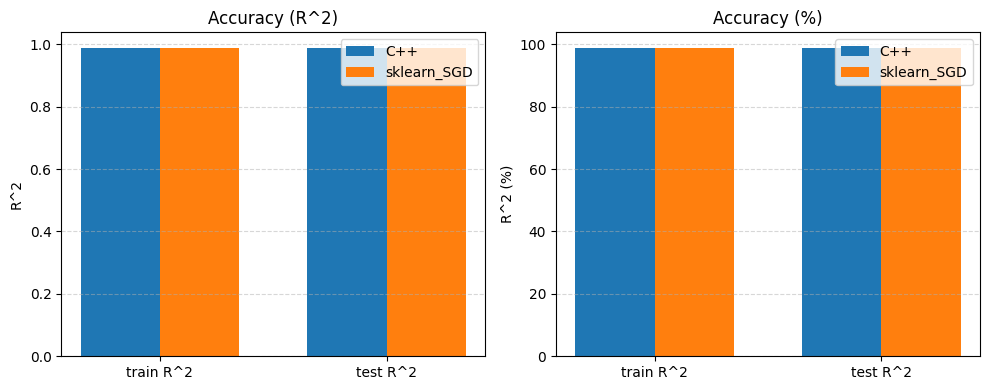

In [2]:
# Accuracy metrics (R^2) and percentage side-by-side
from sklearn.metrics import r2_score

cpp_r2 = r2_score(y_test, cpp_test_pred)
sk_r2 = r2_score(y_test, sk_test_pred)
acc_labels = ['train R^2', 'test R^2']
cpp_acc = [r2_score(y_train, cpp_train_pred), cpp_r2]
sk_acc = [r2_score(y_train, sk_train_pred), sk_r2]
cpp_acc_pct = [v * 100 for v in cpp_acc]
sk_acc_pct = [v * 100 for v in sk_acc]
print(f'C++ R^2 train={cpp_acc[0]:.4f}, test={cpp_acc[1]:.4f} ({cpp_acc_pct[0]:.2f}% / {cpp_acc_pct[1]:.2f}%)')
print(f'Sklearn R^2 train={sk_acc[0]:.4f}, test={sk_acc[1]:.4f} ({sk_acc_pct[0]:.2f}% / {sk_acc_pct[1]:.2f}%)')

fig, axes = plt.subplots(1, 2, figsize=(10,4))
x = np.arange(len(acc_labels))
width = 0.35
axes[0].bar(x - width/2, cpp_acc, width, label='C++')
axes[0].bar(x + width/2, sk_acc, width, label='sklearn_SGD')
axes[0].set_xticks(x); axes[0].set_xticklabels(acc_labels)
axes[0].set_ylabel('R^2')
axes[0].set_title('Accuracy (R^2)')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].legend()

axes[1].bar(x - width/2, cpp_acc_pct, width, label='C++')
axes[1].bar(x + width/2, sk_acc_pct, width, label='sklearn_SGD')
axes[1].set_xticks(x); axes[1].set_xticklabels(acc_labels)
axes[1].set_ylabel('R^2 (%)')
axes[1].set_title('Accuracy (%)')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

